In [56]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,KFold,GridSearchCV
from sklearn.metrics import accuracy_score,fbeta_score,f1_score
import numpy as np
import matplotlib.pyplot as plt
from helpers import make_complexity_curve, make_learning_curve,make_timing_curve,make_timing_curve_fixed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
adult = pd.read_csv('./adult.data.txt',header=None)
adult.columns = ['age','employer','fnlwt','edu','edu_num','marital','occupation','relationship','race','sex','cap_gain','cap_loss','hrs','country','income']
# Note that cap_gain > 0 => cap_loss = 0 and vice versa. Combine variables.
print(adult.ix[adult.cap_gain>0].cap_loss.abs().max())
print(adult.ix[adult.cap_loss>0].cap_gain.abs().max())
adult['cap_gain_loss'] = adult['cap_gain']-adult['cap_loss']
adult = adult.drop(['fnlwt','edu','cap_gain','cap_loss'],1)
adult['income'] = pd.get_dummies(adult.income)
print(adult.groupby('occupation')['occupation'].count())
print(adult.groupby('country').country.count())
#http://scg.sdsu.edu/dataset-adult_r/
replacements = { 'Cambodia':' SE-Asia',
                'Canada':' British-Commonwealth',
                'China':' China',
                'Columbia':' South-America',
                'Cuba':' Other',
                'Dominican-Republic':' Latin-America',
                'Ecuador':' South-America',
                'El-Salvador':' South-America ',
                'England':' British-Commonwealth',
                'France':' Euro_1',
                'Germany':' Euro_1',
                'Greece':' Euro_2',
                'Guatemala':' Latin-America',
                'Haiti':' Latin-America',
                'Holand-Netherlands':' Euro_1',
                'Honduras':' Latin-America',
                'Hong':' China',
                'Hungary':' Euro_2',
                'India':' British-Commonwealth',
                'Iran':' Other',
                'Ireland':' British-Commonwealth',
                'Italy':' Euro_1',
                'Jamaica':' Latin-America',
                'Japan':' Other',
                'Laos':' SE-Asia',
                'Mexico':' Latin-America',
                'Nicaragua':' Latin-America',
                'Outlying-US(Guam-USVI-etc)':' Latin-America',
                'Peru':' South-America',
                'Philippines':' SE-Asia',
                'Poland':' Euro_2',
                'Portugal':' Euro_2',
                'Puerto-Rico':' Latin-America',
                'Scotland':' British-Commonwealth',
                'South':' Euro_2',
                'Taiwan':' China',
                'Thailand':' SE-Asia',
                'Trinadad&Tobago':' Latin-America',
                'United-States':' United-States',
                'Vietnam':' SE-Asia',
                'Yugoslavia':' Euro_2'}
adult['country'] = adult['country'].str.strip()
adult = adult.replace(to_replace={'country':replacements,
                                  'employer':{' Without-pay': ' Never-worked'},
                                  'relationship':{' Husband': 'Spouse',' Wife':'Spouse'}})    
adult['country'] = adult['country'].str.strip()
print(adult.groupby('country').country.count())   
for col in ['employer','marital','occupation','relationship','race','sex','country']:
    adult[col] = adult[col].str.strip()
    
adult = pd.get_dummies(adult)
adult = adult.rename(columns=lambda x: x.replace('-','_'))
adult.shape

0
0
occupation
 ?                    1843
 Adm-clerical         3770
 Armed-Forces            9
 Craft-repair         4099
 Exec-managerial      4066
 Farming-fishing       994
 Handlers-cleaners    1370
 Machine-op-inspct    2002
 Other-service        3295
 Priv-house-serv       149
 Prof-specialty       4140
 Protective-serv       649
 Sales                3650
 Tech-support          928
 Transport-moving     1597
Name: occupation, dtype: int64
country
 ?                               583
 Cambodia                         19
 Canada                          121
 China                            75
 Columbia                         59
 Cuba                             95
 Dominican-Republic               70
 Ecuador                          28
 El-Salvador                     106
 England                          90
 France                           29
 Germany                         137
 Greece                           29
 Guatemala                        64
 Haiti                 

(32561, 57)

In [57]:
adult_df = pd.read_csv(filepath_or_buffer="adult_cleaned.csv")
adult_df_dummies = pd.get_dummies(adult_df.drop('target', 1))
adult_x = adult_df_dummies.copy().values
adult_y = adult_df["target"].copy().values
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(adult_x, adult_y, test_size=0.2,random_state=0)
print(f"adult_df: {adult_df.shape}")
print(f"X_adult_train: {X_adult_train.shape}")
print(f"X_adult_test: {X_adult_test.shape}")
print(f"y_adult_train: {y_adult_train.shape}")
print(f"y_adult_test: {y_adult_test.shape}")
print(f"y_adult_train pos: {(y_adult_train > 0).sum() / len(y_adult_train)}")
print(f"y_adult_train neg: {(y_adult_train == 0).sum() / len(y_adult_train)}")
pipeAdult = Pipeline(
     [('Scale',StandardScaler()),
      ('Cull1',SelectFromModel(RandomForestClassifier(random_state=1),threshold='median')),
      ('Cull2',SelectFromModel(RandomForestClassifier(random_state=2),threshold='median')),
      ('Cull3',SelectFromModel(RandomForestClassifier(random_state=3),threshold='median')),
      ('Cull4',SelectFromModel(RandomForestClassifier(random_state=4),threshold='median'))
     ]
)
X_trans_adult_train = pipeAdult.fit_transform(X_adult_train, y_adult_train)
print(f"X_tran_adult_train: {X_trans_adult_train.shape}")
print(f"Percentage feature removed: {1 - (X_trans_adult_train.shape[1] / X_adult_train.shape[1])}")

adult_df: (30162, 15)
X_adult_train: (24129, 104)
X_adult_test: (6033, 104)
y_adult_train: (24129,)
y_adult_test: (6033,)
y_adult_train pos: 0.2489535413817398
y_adult_train neg: 0.7510464586182601
X_tran_adult_train: (24129, 7)
Percentage feature removed: 0.9326923076923077


In [58]:
spam_df = pd.read_csv('spambase2.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(spam_x, spam_y, test_size=0.2,random_state=0)
print(f"spam_df: {spam_df.shape}")
print(f"X_spam_train: {X_spam_train.shape}")
print(f"X_spam_test: {X_spam_test.shape}")
print(f"y_spam_train: {y_spam_train.shape}")
print(f"y_spam_test: {y_spam_test.shape}")
print(f"y_spam_train pos: {(y_spam_train > 0).sum() / len(y_spam_train)}")
print(f"y_spam_train neg: {(y_spam_train == 0).sum() / len(y_spam_train)}")
pipeSpam = Pipeline(
    [('Scale',StandardScaler()),
      ('Cull1',SelectFromModel(RandomForestClassifier(random_state=1),threshold='median')),
      ('Cull2',SelectFromModel(RandomForestClassifier(random_state=2),threshold='median')),
      ('Cull3',SelectFromModel(RandomForestClassifier(random_state=3),threshold='median')),
      ('Cull4',SelectFromModel(RandomForestClassifier(random_state=4),threshold='median'))
    ]
)
X_trans_spam_train = pipeSpam.fit_transform(X_spam_train, y_spam_train)
print(f"X_tran_spam_train: {X_trans_spam_train.shape}")
print(f"Percentage feature removed: {1 - (X_trans_spam_train.shape[1] / X_spam_train.shape[1])}")

spam_df: (4601, 58)
X_spam_train: (3680, 57)
X_spam_test: (921, 57)
y_spam_train: (3680,)
y_spam_test: (921,)
y_spam_train pos: 0.38858695652173914
y_spam_train neg: 0.6114130434782609
X_tran_spam_train: (3680, 4)
Percentage feature removed: 0.9298245614035088


In [59]:
adult_params = {
    'n_estimators': list(range(1, 100, 10)),
    'base_estimator__max_depth': list(np.arange(1, 30, 1)),
    'learning_rate': [0.01,0.05,0.1,0.3,1]
}

spam_params = {
    'n_estimators': list(range(1, 100, 10)),
    'base_estimator__max_depth': list(np.arange(1, 30, 1)),
    'learning_rate': [0.01,0.05,0.1,0.3,1]
}

In [68]:
adult_cv = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=123)),param_grid=adult_params, cv=5)
adult_cv.fit(X_trans_adult_train, y_adult_train)
print(f"best params adult: {adult_cv.best_params_}")

best params adult: {'base_estimator__max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 71}


In [67]:
spam_cv = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=123),random_state=123),param_grid=spam_params, cv=5)
spam_cv.fit(X_trans_spam_train, y_spam_train)
spam_cv.best_params_
print(f"best params spam: {spam_cv.best_params_}")

best params spam: {'base_estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 91}


**Complexity**

In [104]:
adult_cc_estimators = make_complexity_curve(adult_cv.best_estimator_, X_trans_adult_train.astype(float), y_adult_train.astype(float), "n_estimators", list(range(1, 500, 10)),"boosting complexity n_estimators", "adult")

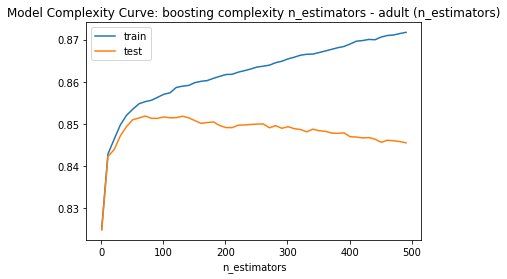

In [105]:
adult_cc_estimators.plot(title=adult_cc_estimators.name)

In [106]:
spam_cc_estimators = make_complexity_curve(spam_cv.best_estimator_, X_trans_spam_train.astype(float), y_spam_train.astype(float), "n_estimators", list(range(1, 500, 10)),"boosting complexity n_estimators", "spam")

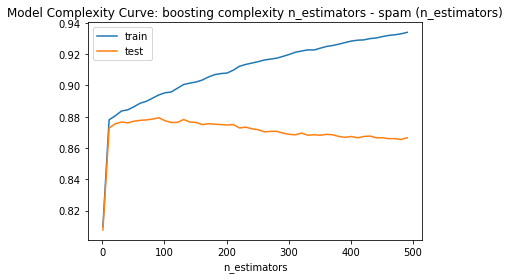

In [107]:
spam_cc_estimators.plot(title=spam_cc_estimators.name)

In [108]:
adult_cc_learning_rate = make_complexity_curve(adult_cv.best_estimator_, X_trans_adult_train.astype(float), y_adult_train.astype(float), "learning_rate", [0.01,0.05,0.1,0.3,1],"boosting complexity learning rate", "adult")

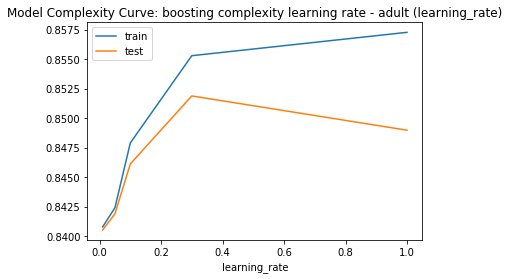

In [109]:
adult_cc_learning_rate.plot(title=adult_cc_learning_rate.name)

In [83]:
spam_cc_learning_rate = make_complexity_curve(spam_cv.best_estimator_, X_trans_spam_train.astype(float), y_spam_train.astype(float), "learning_rate", [0.01,0.05,0.1,0.3,1], "boosting complexity learning rate", "spam")

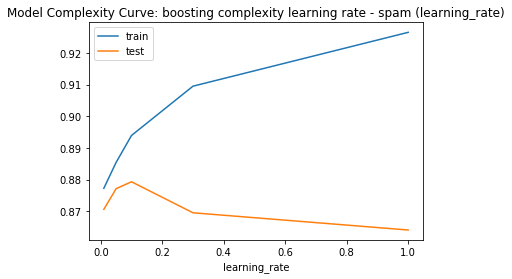

In [84]:
spam_cc_learning_rate.plot(title=spam_cc_learning_rate.name)

In [85]:
adult_cc_md = make_complexity_curve(adult_cv.best_estimator_, X_trans_adult_train.astype(float), y_adult_train.astype(float), "base_estimator__max_depth", list(np.arange(1, 30, 1)),"boosting complexity learning rate", "adult")

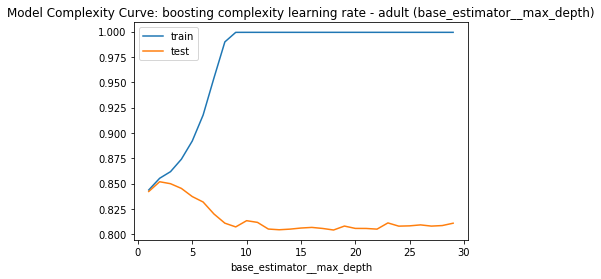

In [86]:
adult_cc_md.plot(title=adult_cc_md.name)

In [87]:
spam_cc_md = make_complexity_curve(spam_cv.best_estimator_, X_trans_spam_train.astype(float), y_spam_train.astype(float), "base_estimator__max_depth", list(np.arange(1, 30, 1)),"boosting complexity learning rate", "spam")

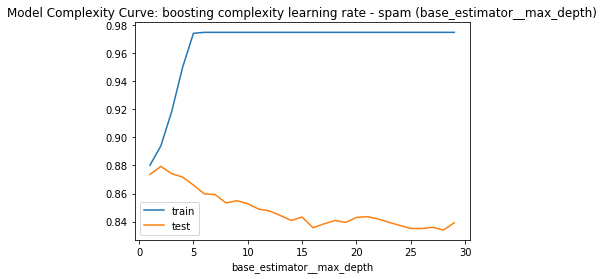

In [88]:
spam_cc_md.plot(title=spam_cc_md.name)

**Timing curve**

In [90]:
adult_timing = make_timing_curve(adult_cv.best_estimator_,X_trans_adult_train.astype(float), y_adult_train.astype(float),'boositng timing', 'adult')

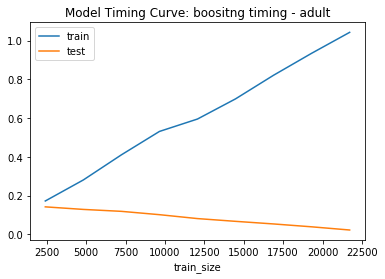

In [91]:
adult_timing.plot(title=adult_timing.name)

In [94]:
spam_timing = make_timing_curve(spam_cv.best_estimator_,X_trans_spam_train.astype(float), y_spam_train.astype(float),'boositng timing', 'spam')

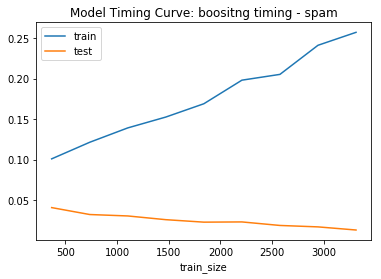

In [99]:
spam_timing.plot(title=spam_timing.name)

**Learning Curve**

In [100]:
adult_lc = make_learning_curve(adult_cv.best_estimator_,X_trans_adult_train.astype(float), y_adult_train.astype(float),np.linspace(0.1, 1.0, 10),'boosting timing', 'adult')

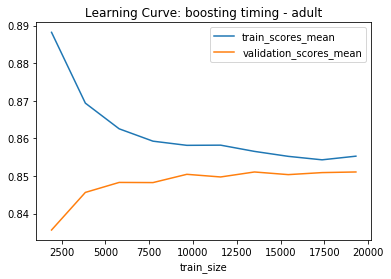

In [101]:
adult_lc.plot(title=adult_lc.name)

In [102]:
spam_lc = make_learning_curve(spam_cv.best_estimator_,X_trans_spam_train.astype(float), y_spam_train.astype(float),np.linspace(0.1, 1.0, 10),'boosting timing', 'spam')

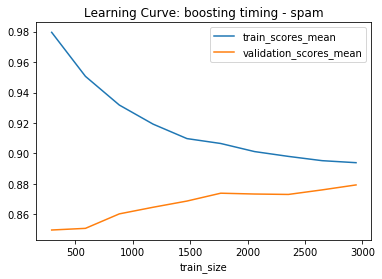

In [103]:
spam_lc.plot(title=spam_lc.name)